<a href="https://colab.research.google.com/github/SabaJazi/EA-Chatbot/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0- Libraries

In [2]:
# import necessary library
import sys
# to avoid NumPy's truncation of outputs when certain code blocks are generated

import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np 
np.set_printoptions(threshold=sys.maxsize)
import os # accessing directory structure
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#**Section1:  Data**

## **step 1: Create Dataset**


In [ ]:
# get data file from google drive
# from google.colab import files
# files.upload()

## **Step 2. Load the dataset**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
 
from pathlib import Path
df=pd.read_csv("/content/drive/MyDrive/tweet_emotions.csv")
df.head


<bound method NDFrame.head of          tweet_id  ...                                            content
0      1956967341  ...  @tiffanylue i know  i was listenin to bad habi...
1      1956967666  ...  Layin n bed with a headache  ughhhh...waitin o...
2      1956967696  ...                Funeral ceremony...gloomy friday...
3      1956967789  ...               wants to hang out with friends SOON!
4      1956968416  ...  @dannycastillo We want to trade with someone w...
...           ...  ...                                                ...
39995  1753918954  ...                                   @JohnLloydTaylor
39996  1753919001  ...                     Happy Mothers Day  All my love
39997  1753919005  ...  Happy Mother's Day to all the mommies out ther...
39998  1753919043  ...  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39999  1753919049  ...  @mopedronin bullet train from tokyo    the gf ...

[40000 rows x 3 columns]>

##**Step3: EDA**

In [11]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

In [12]:
basic_eda(df)

Info : There are 3 columns in the dataset
Info : There are 40000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['sentiment', 'content']
Numerical columns :  ['tweet_id']


,column_name,dtype
0,tweet_id,int64
1,sentiment,object
2,content,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,tweet_id,40000.0,1.845184e+09,1.188579e+08,1.693956e+09,1.751431e+09,1.855443e+09,1.962781e+09,1.966441e+09



Description of categorical variables


,column_name,count,unique,top,freq
0,sentiment,40000,13,neutral,8638
1,content,40000,39827,I just received a mothers day card from my lov...,14


##*checking for null values*

In [13]:
total = df.isnull().sum()
total

tweet_id     0
sentiment    0
content      0
dtype: int64

**Distribution of sentiments in the data**

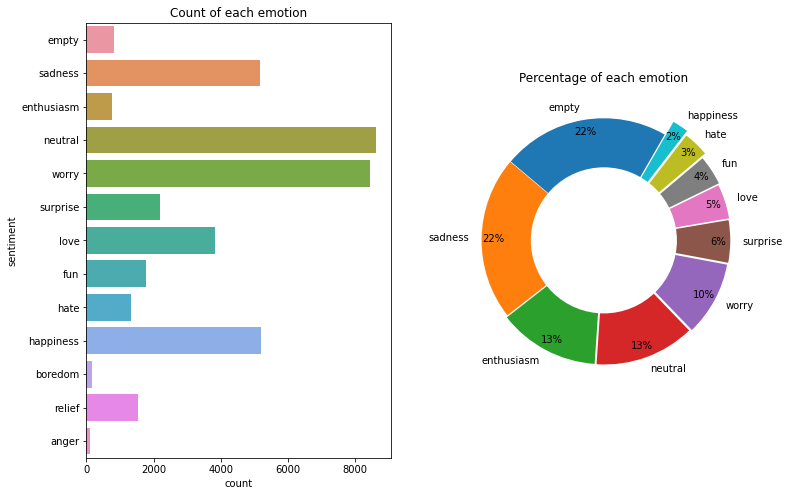

In [15]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

Reducing the number of classes since the dataset is messy and will cause issues for our model to converge.

In [16]:
df['sentiment'] = df['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'neutral', 'love'] else "other") 

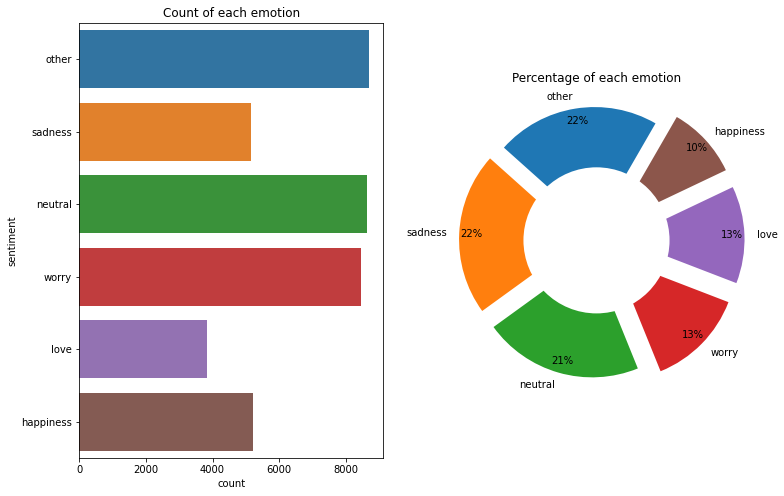

In [17]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [18]:
df['char_length'] = df['content'].apply(lambda x : len(x))
df['token_length'] = df['content'].apply(lambda x : len(x.split(" ")))

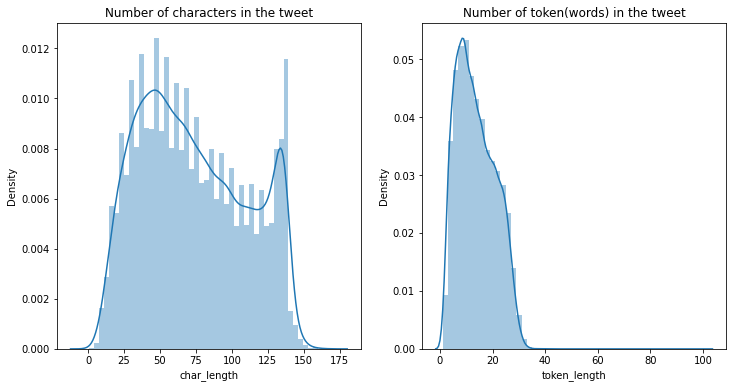

In [19]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(df['char_length'], ax=ax1)
sns.distplot(df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

Finding the most common character and token length

In [20]:
avg_df = df.groupby('sentiment').agg({'char_length':'mean', 'token_length':'mean'})

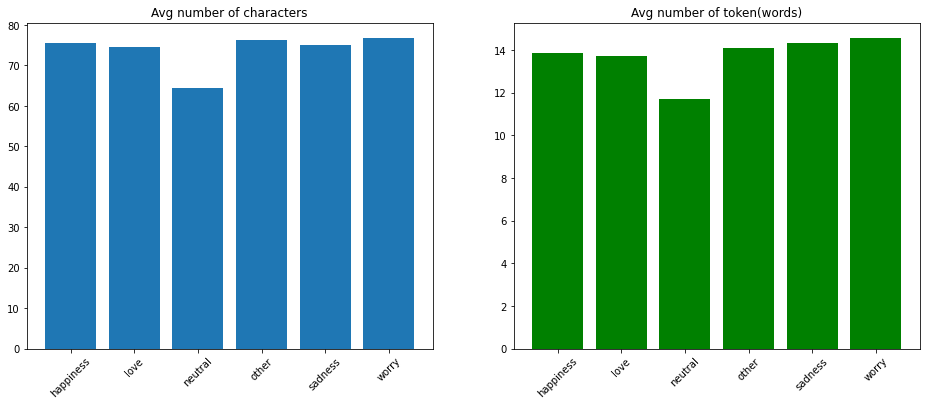

In [21]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

##**Step4: Clean Data and preprocessing**


In [ ]:
raw_data=pd.DataFrame(columns=['Text','Category'])
raw_data['Text']=df['content']
raw_data['Category']=df['sentiment']
raw_data

,Text,Category
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral
...,...,...
39995,@JohnLloydTaylor,neutral
39996,Happy Mothers Day All my love,love
39997,Happy Mother's Day to all the mommies out ther...,love
39998,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness


In [ ]:
import re 

text_string="@13tif_fanylue13 i know @i_dulay i was @mselliott09 @XO_SUFI_XO listenin to bad habit earlier and i started freakin at his part =["

def clean_text(text_string):
  remove_user= re.sub('@[A-Z?a-z?_?0-9?]+', '', text_string)
  return re.sub('[^a-zA-Z0-9 ]', '', remove_user.lower())

clean_text(text_string)

' i know  i was   listenin to bad habit earlier and i started freakin at his part '

In [ ]:
clean_data=pd.DataFrame(columns=['Text','Category'])

In [ ]:
l=[]
for i in raw_data['Text']:
  l.append(clean_text(i))
clean_data['Text']=l
clean_data['Category']=raw_data['Category']
clean_data


,Text,Category
0,i know i was listenin to bad habit earlier a...,empty
1,layin n bed with a headache ughhhhwaitin on y...,sadness
2,funeral ceremonygloomy friday,sadness
3,wants to hang out with friends soon,enthusiasm
4,we want to trade with someone who has houston...,neutral
...,...,...
39995,,neutral
39996,happy mothers day all my love,love
39997,happy mothers day to all the mommies out there...,love
39998,wassup beautiful follow me peep out my new h...,happiness


##step4: **Split Data**

In [ ]:
#split dataset into train, validation, and test set
train_X=clean_data['Text'][:30000]
train_Y=clean_data['Category'][:30000]
val_X=clean_data['Text'][30000:35000]
val_Y=clean_data['Category'][30000:35000]
text_X=clean_data['Text'][35000:]
text_Y=clean_data['Category'][35000:]

#**Section 2: Build and evaluate several model**

##**model1: **Model 1:Naive Bayes model**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer()
#  create BoW representation the training set
train_X_enc = vector.fit_transform(train_X)
train_X_enc=train_X_enc.toarray()
val_X = vector.transform(val_X)
val_X=val_X.toarray()



In [ ]:
from sklearn import preprocessing
#fit train label into LabelEncoder()
enc = preprocessing.LabelEncoder()
enc.fit(train_Y)
train_Y_enc=enc.transform(train_Y)
val_Y_enc=enc.transform(val_Y)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
MNB_model = MultinomialNB()
MNB_model.fit(train_X_enc, train_Y_enc)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
predict=MNB_model.predict(val_X)
predict

array([12, 12,  8,  8,  7,  8,  8,  8,  8, 12,  8, 12,  7, 12, 10,  5, 10,
       12,  5,  8,  8,  7,  8,  8, 12,  5, 10,  8, 12, 12, 12, 10, 12,  5,
        8,  8,  8, 12, 10, 12,  7, 10,  8, 12,  5,  8,  8,  4, 12, 12,  8,
       12, 12,  5,  8, 12,  8, 12,  5,  8, 12,  8, 12, 12,  8,  8, 12,  5,
        5,  8, 12,  5, 12, 12, 10,  7,  8,  8, 12, 12, 12, 12, 10, 10,  5,
       10,  8, 12,  8, 12, 12,  5, 12, 12, 12, 10, 12, 12,  8,  8,  8,  7,
       12, 12, 12, 12, 12,  7,  5, 12,  8,  5, 12, 12, 12,  8, 10,  8, 12,
        8, 12,  8,  8, 12, 12, 12, 12,  8, 12,  5, 12, 10, 12, 12,  8,  8,
       12, 12, 12,  8,  8,  5, 12, 12, 12,  7,  8, 12, 12, 12, 12,  7, 12,
       12, 12, 12, 12,  8,  5, 12, 12, 12, 12,  5, 12, 12,  8,  8, 12,  8,
       12, 12, 12, 12,  7, 12,  8,  5, 10,  8,  5,  8, 12, 12, 12,  8, 12,
       12, 12, 12, 12, 12, 12, 10,  5, 12,  8, 12,  8,  8, 12,  8, 12, 12,
        5,  8, 12, 12, 12, 12, 12,  8,  8,  5, 12,  5,  8,  8,  5, 12,  5,
       12, 12, 12, 12, 12

In [ ]:
# importing the metrics module from sklearn
from sklearn import metrics

# use the accuracy_score metric to calculate accuracy of the MNB_model

accuracy = metrics.accuracy_score(val_Y_enc, predict)
accuracy

0.225